# Summary

$F = ma$

Compute $m$, $a$, then determine the amount of
force $F$ in a healthy repo at a given time. The ideal
theory here is that acceleration will start decreasing as
a project is about to die.

In [1]:
from collections import defaultdict
import os
from urllib.parse import urljoin

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from okra.playbooks import local_persistance
from okra.models import (Meta, Author, Contrib, CommitFile, Info)
from okra.models import DataAccessLayer

In [2]:
DATA = "/Users/tylerbrown/code/"
repos = [
    "torvalds/linux",
    "docker/docker-ce",
    'apache/attic-lucy',
    'apache/attic-wink',
    'apache/spark',
    'apache/lucene-solr'
]

for repo_name in repos:
    local_persistance(repo_name, DATA)

Issue with row 0, repo '/Users/tylerbrown/code/torvalds/linux'
Issue with row 0, repo '/Users/tylerbrown/code/docker/docker-ce'
Issue with row 0, repo '/Users/tylerbrown/code/apache/attic-lucy'
Issue with row 0, repo '/Users/tylerbrown/code/apache/attic-wink'
Issue with row 0, repo '/Users/tylerbrown/code/apache/spark'
Issue with row 0, repo '/Users/tylerbrown/code/apache/lucene-solr'


In [3]:
def date_transform(datedict):
    these = {}
    for key in datedict.keys():
        item = datedict[key]
        new_key = str(item.year) + '-' + str(item.dayofyear)
        these[new_key] = item
    return these

def author_transform(autdict):
    items = defaultdict(list)
    for idx in range(len(autdict['commit_hash'])):
        
        new_key = str(autdict['date_authored'][idx].year) + '-' + str(autdict['date_authored'][idx].dayofyear)
        new_item = (autdict['author_email'][idx], autdict['author_name'][idx], 
                    autdict['commit_hash'][idx], autdict['date_authored'][idx], 
                    autdict['lines_added'][idx], autdict['lines_deleted'][idx])
        items[new_key].append(new_item)
        
    return items

def date_join(autht, datet):
    
    rows = []
    r = {
        'date_key': np.NaN,
        'author_email': np.NaN,
        'author_name': np.NaN,
        'commit_hash': np.NaN,
        'date_authored': np.NaN,
        'lines_added': np.NaN,
        'lines_deleted': np.NaN,
    }

    for date_key in datet.keys():
        
        if date_key in autht:
            
            for i in autht[date_key]:
                
                rd = r.copy()
                rd['date_key'] = date_key
                rd['author_email'] = i[0]
                rd['author_name'] = i[1]
                rd['commit_hash'] = i[2]
                rd['date_authored'] = i[3]
                rd['lines_added'] = i[4]
                rd['lines_deleted'] = i[5]
                
                rows.append(rd)
    return rows

In [4]:
repodbs = {i : i.replace("/", "__REPODB__") + ".db" for i in repos}
repodbs

{'torvalds/linux': 'torvalds__REPODB__linux.db',
 'docker/docker-ce': 'docker__REPODB__docker-ce.db',
 'apache/attic-lucy': 'apache__REPODB__attic-lucy.db',
 'apache/attic-wink': 'apache__REPODB__attic-wink.db',
 'apache/spark': 'apache__REPODB__spark.db',
 'apache/lucene-solr': 'apache__REPODB__lucene-solr.db'}

In [5]:
conn_string = "sqlite:///" + urljoin(DATA, repodbs['torvalds/linux'])

In [6]:
dal = DataAccessLayer(conn_string)
dal.connect()
dal.session = dal.Session()

In [7]:
# let's do this by author per file now

q5 = dal.session.query(
    Meta.commit_hash, Author.authored, Author.name, Author.email,
    CommitFile.lines_added, CommitFile.lines_deleted
).join(Author).join(CommitFile)

items = []
for item in q5.all():
    r = {
        "commit_hash": item.commit_hash,
        "date_authored": item.authored,
        "author_name": item.name,
        "author_email": item.email,
        "lines_added": item.lines_added,
        "lines_deleted": item.lines_deleted,
    }
    items.append(r)
autdf = pd.DataFrame(items)
print(autdf.shape)

(1824726, 6)


## Mass

Compute the repo mass over time

In [26]:
def current_mass(i, df):
    if i > 0:
        x = df.lines_added.iloc[i] - df.lines_deleted.iloc[i] + df.current_mass.iloc[i-1]
        return x
    else:
        return 0

def compute_mass(df):
    mass = []
    for i in range(df.shape[0]):
        mass.append(current_mass(i, df))
    return np.array(mass)
    

In [54]:
autdf['current_mass'] = 0

In [55]:
autdf = autdf.sort_values(by='date_authored')

In [56]:
m = autdf[['lines_added', 'lines_deleted', 'current_mass']].values

In [57]:
md = (m[:,0] - m[:,1])
for i in range(m[:,2].shape[0]):
    
    if i > 0:
        m[i,2] = md[i] + m[i-1,2]
    else:
        m[i,2] = md[i] + 0
    

In [58]:
autdf.current_mass = m[:,2]

In [67]:
autdf['authordt'] = pd.to_datetime(autdf.date_authored)

In [81]:
per = autdf.authordt.dt.to_period("M")

In [97]:
massdt = autdf[['current_mass', 'authordt']][(autdf.authordt > '2005-01') & (autdf.authordt <= '2019-01')].groupby(per).sum()

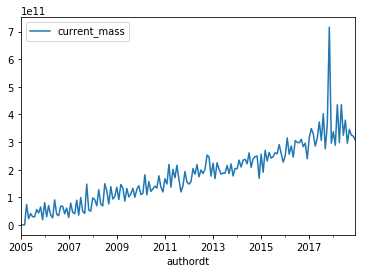

In [98]:
massdt.plot()

## Compute acceleration

Compute acceleration over time. Velocity

$v = \frac{d}{t}$

Acceleration

$a = v \frac{dx}{dt} = v(x)_{t} - v(x)_{t-1}$

In terms of Git

$(lines\_added - lines\_deleted)_{t} - (lines\_added - lines\_deleted)_{t-1} \forall \text{ }developers$